# Web Scraping

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests

In [2]:
weblink = "https://www.spotrac.com/mlb/rankings/2020/salary/"
response = requests.get(weblink)
read_text = response.text

#Create an instance of the BeautifulSoup class in order to begin the webscraping process
soup = BeautifulSoup(read_text)

#Gathers all of the hyperlinks from the websites  (href = True) and prints the titles of them through the .text
for x in soup.find_all('a', href = True):
    print(x.text.strip())




PREMIUM
Sign In
Register
NEWS
PODCASTS

NFL
Team Salary Caps
Positional Spending
Contracts
Salary Rankings
Free Agents

Trackers & Tools
» Market Values
» Fines/Suspensions
» IR Tracker
» Depth Charts Tracker
» Draft Tracker
» Options
» College Tracker
Best Values
Transactions

NBA
Team Cap Tracker
Positional Payrolls
Contracts
Salary Rankings
Free Agents

Trackers & Tools
» Depth Charts
» Options
» Fines/Suspensions
» Draft Tracker
» College Tracker
» Awards Tracker
Best Values

Transactions
» Recent Transactions
» Extensions
» Trades

MLB
Team Payrolls
Luxury Tax Tracker
Positional Payrolls
Contracts
Salary Rankings
Free Agents
Prospects

Trackers & Tools
» Fines/Suspensions
» Injured List Tracker
» Options Tracker
» Trade Tracker
» Arbitration Tracker
Best Values
Transactions

NHL
Team Salary Caps
Positional Payrolls
Contracts
Salary Rankings
Free Agents

Trackers & Tools
» IR Tracker
» Options
» Fines/Suspensions
» Draft Tracker
» Trade Tracker
» College/Junior Team Tracker
» Co

In [3]:
#Gets the title of the website
print(soup.title.text + '\n')

#Prints the first paragraph of text with the website
print(soup.find('p').text + '\n')

#Find the first heading in the website
print(soup.find('h1').text + '\n')

#Finds the children of the entire website (which can be seen as HTML)
print(soup.contents[0].upper())

MLB Salary Rankings | Spotrac

When you visit any web site, it may store or retrieve information on your browser, mostly in the form of cookies. This information might be about you, your preferences or your device and is mostly used to make the site work as you expect it to. The information does not usually directly identify you, but it can give you a more personalised web experience. Because we respect your right to privacy, you can choose not to allow some types of cookies. Click on the different category headings to find out more and change our default settings. However, blocking some types of cookies may impact your experience of the site and the services we are able to offer.

MLB Financial Rankings

HTML


# Beautiful Soup Implementation

In [4]:
#Since a lot of the page begins to load in as we scroll through the page, we need this to gather all of the information
response = requests.post(weblink, data={'ajax': 'true','mobile': 'false'}).content

soup = BeautifulSoup(response)

#Tr tags in html establish rows of a table. Therefore, we need to find these rows in the table to properly scrape the data
column_headers = soup.find_all('tr')[0]

#Goes through all of the header cells and formats them correctly to score them in the table
column_headers = [i.text.strip().title() for i in column_headers.find_all('th')]
column_headers = column_headers[1:]

#This accesses each block or row of the players in the website
baseballPlayers = soup.find_all('tr')[1:]

playerName = []
position = []
age = []
salary = []
team = []

#Iterate through all of the baseball players and store their information in the table
for player in baseballPlayers:
    #Accesses all h3 href attributes in order to properly find the player name
    playerName.append(player.h3.a.text)
    #Looks for the center small class which is where the position of the player is found
    position.append(player.find('td', class_ = 'center small').text.strip())
    #Finds the salary and gets rid of the dollar sign because we want to convert this to a numeric type later
    salary.append(player.find('span', class_ = 'info').text.strip().replace('$',""))
    #Looks for each div tag with the specific class and formats correctly
    team.append(player.find('div', class_ = 'rank-position').text.strip())
    #There are two types of center small classes, so we have to access the number attributes to gather the age
    for ages in player.find_all("td", {"class": "center small"}):
        plainText = ages.text.strip()
        
        #If its numeric, we know that it is for the age
        if(plainText.isnumeric()):
            age.append(plainText)

#Formats all of the data in the list into a pandas dataframe to gather all of the information properly
playerData = pd.DataFrame({"Player": playerName, 'Team': team, 'Age':age,"Position" : position, "Salary": salary})
playerData

,Player,Team,Age,Position,Salary
0,Mike Trout,LAA,28,CF,"37,766,667"
1,Gerrit Cole,NYY,29,SP,"36,000,000"
2,Max Scherzer,WSH,35,SP,"35,920,616"
3,Nolan Arenado,COL,29,3B,"35,025,000"
4,Stephen Strasburg,WSH,31,SP,"35,000,000"
...,...,...,...,...,...
995,Sergio Alcantara,DET,23,2B,"563,500"
996,Alejandro Kirk,TOR,21,C,"563,500"
997,Jorge Bonifacio,DET,27,RF,"563,500"
998,Kyle Zimmer,KC,28,RP,"563,500"


# Pandas Implementation

In [5]:
#Downside only accesses the first 100 rows
#Since the rest of the data must be accesses by scrolling, if you wanted to use pandas read_html function you would
#have to use selenium to figure the rest out
dfs = pd.read_html(weblink, header = 0)[0].reset_index()

#Only accesses the relevant attributes from the dataframe
dfs = dfs[['Player','POS','Age','salary']]

#Converts all of the columns to titlecase
dfs.columns = dfs.columns.str.title()
#gets rid of all NaN values
dfs.dropna(inplace = True)

#Ensures that the team will be accesses instead of a player column with the team attached to the end of the player name
dfs['Team'] = dfs['Player'].str.split(" ", n = 2, expand = True)[2]
dfs['Player'] = dfs['Player'].str[:-4]
dfs

,Player,Pos,Age,Salary,Team
0,Mike Trout,CF,28,"$37,766,667",LAA
1,Gerrit Cole,SP,29,"$36,000,000",NYY
2,Max Scherzer,SP,35,"$35,920,616",WSH
3,Nolan Arenado,3B,29,"$35,025,000",COL
4,Stephen Strasburg,SP,31,"$35,000,000",WSH
...,...,...,...,...,...
95,Alex Bregman,3B,26,"$13,000,000",HOU
96,Josh Reddick,RF,33,"$13,000,000",HOU
97,Marcus Semien,SS,29,"$13,000,000",OAK
98,Tyler Chatwood,SP,30,"$13,000,000",CHC


In [6]:
#Want to scrape 25 pages from the 2020 season to compare players and salary
hitData = pd.DataFrame()

#Want to scrape all of the 25 pages from the MLB database
link = "https://www.mlb.com/stats/doubles/2020"
for i in range(2, 25):
    r = requests.get(link)
    #Keeps adding rows to the dataframe column with each page
    hitData = pd.concat([hitData, (pd.read_html(r.text, header = 0)[0])])
    link = f"https://www.mlb.com/stats/doubles/2020?page={i}"

#Resets the index to make accessing elements easier
hitData = hitData.reset_index()
hitData.drop('index', axis = 1, inplace = True)

#Renaming all of the columns to get rid of an errors that may have been produced with webscraping
column_headers = ['Player', 'Team', 'Games Played', 'At Bats', 'Runs', 'Hits', 'Doubles', 'Triples', 'Home Runs', 'RBIs',
                 'Walks','Strikeouts', 'Stolen Bases', 'Caught Stealing', 'Batting Average', 'On Base Percentage', 
                 'Slugging Percentage', 'On Base Plus Slugging']

hitData.columns = column_headers

#Wants to split the player column with any capital letters that it may find
replaceNames = hitData['Player'].str.findall('[A-Z][^A-Z]*')

playerNames = []

#Appends each name in the list with the first and last name, assigning it to the new Player column
for names in replaceNames:
    playerNames.append(names[0] + " " + names[2])
    
hitData['Player'] = playerNames
hitData

,Player,Team,Games Played,At Bats,Runs,Hits,Doubles,Triples,Home Runs,RBIs,Walks,Strikeouts,Stolen Bases,Caught Stealing,Batting Average,On Base Percentage,Slugging Percentage,On Base Plus Slugging
0,Freddie Freeman,ATL,60,214,51,73,23,1,13,53,45,37,2,0,0.341,0.462,0.640,1.102
1,Dominic Smith,NYM,50,177,27,56,21,1,10,42,14,45,0,0,0.316,0.377,0.616,0.993
2,Cesar Hernández,CLE,58,233,35,66,20,0,3,20,24,57,0,0,0.283,0.355,0.408,0.763
3,Christian Walker,AZ,57,218,35,59,18,1,7,34,19,50,1,1,0.271,0.333,0.459,0.792
4,Jose Iglesias,BAL,39,142,16,53,17,0,3,24,3,17,0,0,0.373,0.400,0.556,0.956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,Brian Navarreto,MIA,2,5,0,2,0,0,0,0,0,1,0,0,0.400,0.400,0.400,0.800
571,Hector Neris,PHI,24,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000
572,John Nogowski,STL,1,4,0,1,0,0,0,0,0,1,0,0,0.250,0.250,0.250,0.500
573,Aaron Nola,PHI,12,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000


In [7]:
#Inner join to add the salary column to properly make calculations on the data
overallData = pd.merge(playerData, hitData, on = ['Player','Team'], how = 'inner')

#Convert the salary column to a float to make performing calulations on easier
overallData['Salary'] = overallData['Salary'].str.replace(',', "").astype(float)
overallData

,Player,Team,Age,Position,Salary,Games Played,At Bats,Runs,Hits,Doubles,...,Home Runs,RBIs,Walks,Strikeouts,Stolen Bases,Caught Stealing,Batting Average,On Base Percentage,Slugging Percentage,On Base Plus Slugging
0,Mike Trout,LAA,28,CF,37766667.0,53,199,41,56,9,...,17,46,35,56,1,1,0.281,0.390,0.603,0.993
1,Nolan Arenado,COL,29,3B,35025000.0,48,182,23,46,9,...,8,26,15,20,0,0,0.253,0.303,0.434,0.737
2,Manny Machado,SD,27,3B,32000000.0,60,224,44,68,12,...,16,47,26,37,6,3,0.304,0.370,0.580,0.950
3,Miguel Cabrera,DET,37,DH,30000000.0,57,204,28,51,4,...,10,35,24,51,1,0,0.250,0.329,0.417,0.746
4,Albert Pujols,LAA,40,1B,29000000.0,39,152,15,34,8,...,6,25,9,25,0,0,0.224,0.270,0.395,0.665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,Pat Valaika,BAL,27,SS,563500.0,52,141,24,39,4,...,8,16,8,34,0,2,0.277,0.315,0.475,0.790
311,Nick Heath,KC,26,OF,563500.0,15,13,2,2,1,...,0,3,2,6,2,2,0.154,0.313,0.231,0.544
312,Edward Olivares,KC,24,OF,563500.0,31,96,9,23,2,...,3,10,4,25,0,2,0.240,0.267,0.375,0.642
313,Alejandro Kirk,TOR,21,C,563500.0,9,24,4,9,2,...,1,3,1,4,0,0,0.375,0.400,0.583,0.983


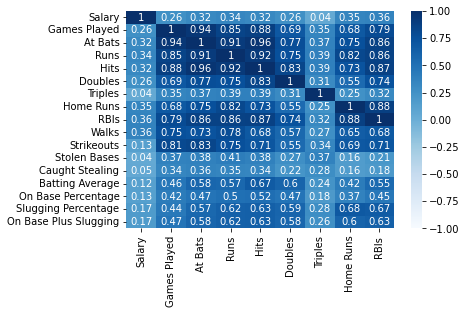

<Figure size 1800x720 with 0 Axes>

In [8]:
corrMatrix = round(overallData.corr(), 2)
corrMatrix = corrMatrix[corrMatrix.columns[0:9]]

#This correlation matrix will show the dependency of variables within different categories
#The close the value to one, the more related the variables are to one another
sns.heatmap(corrMatrix, annot = True, vmin = -1, vmax = 1, cmap ='Blues')
plt.figure(figsize = (25,10))
plt.show()

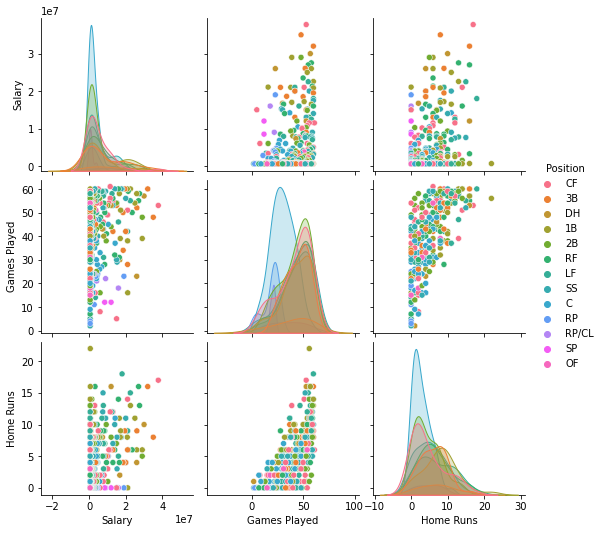

In [9]:
#Pairplot categorized based on position
sns.pairplot(overallData, vars=['Salary', 'Games Played', 'Home Runs'], hue='Position')

<Figure size 1152x720 with 0 Axes>

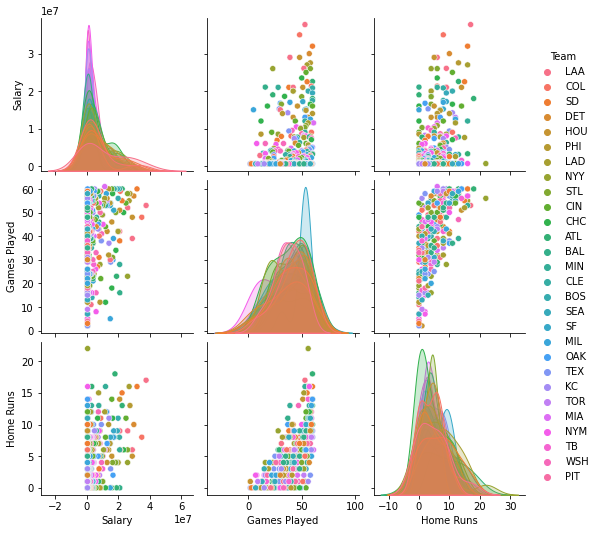

In [10]:
#Pairplot categorized based on team
plt.figure(figsize=(16,10))
sns.pairplot(overallData, vars=['Salary', 'Games Played', 'Home Runs'], hue='Team')

<AxesSubplot:xlabel='Team', ylabel='Salary'>

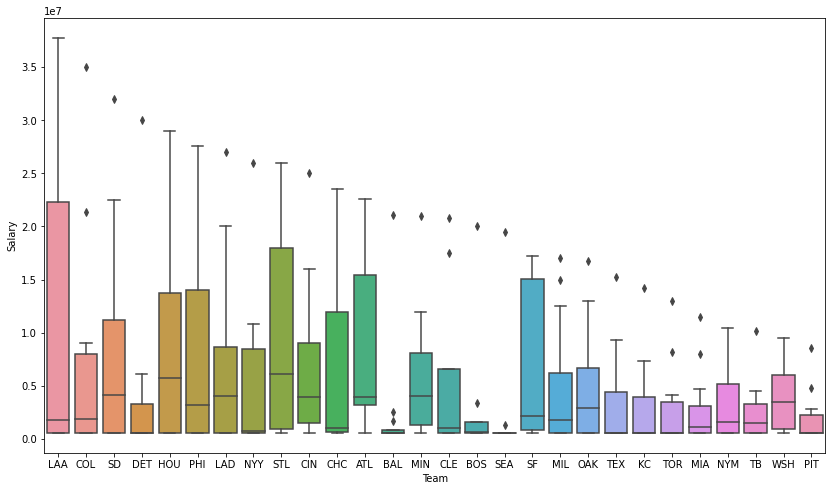

In [11]:
#Box plots that visualize spending across all teams
plt.figure(figsize=(14,8))
sns.boxplot(data=overallData, x='Team', y='Salary')

<AxesSubplot:xlabel='Position', ylabel='Salary'>

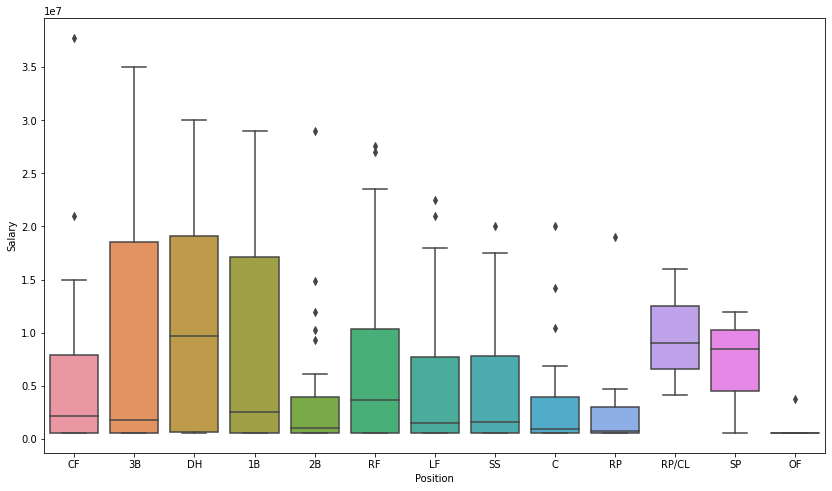

In [12]:
#Box plots that visualize the salary distribution between different positions
plt.figure(figsize=(14,8))
sns.boxplot(data=overallData, x='Position', y='Salary')

# Linear Regression Model

## This model shows the correlation between a player's salary and the amount of home runs they get 

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X = overallData['Home Runs'].values.reshape(-1,1)
Y = overallData['Salary'].values.reshape(-1,1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

#Defines and builds the model
model = LinearRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

In [14]:
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("Mean Squared Error (MSE): %.2f" % mean_squared_error(Y_test, Y_pred))
print("Coefficient of determination (R^2): %.2f" % r2_score(Y_test, Y_pred))

Coefficients: [[644499.78979149]]
Intercept: [2187365.75407906]
Mean Squared Error (MSE): 58366511947854.16
Coefficient of determination (R^2): 0.09


<function matplotlib.pyplot.show(close=None, block=None)>

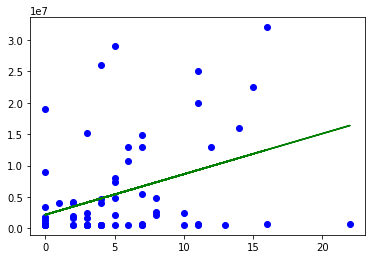

In [15]:
plt.scatter(X_test, Y_test, color ='b')
plt.plot(X_test, Y_pred, color ='g')
plt.show